# Skin Disease Pytorch Lightning CNN

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from torch.utils.data import DataLoader, WeightedRandomSampler
import pytorch_lightning as pl
from torchvision import datasets, transforms
from collections import Counter
from torchsummary import summary


In [2]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [3]:
dataset0=datasets.ImageFolder(root="DataSet/Skin Disease/Skin Cancer Dataset",transform=None)

class_names=dataset0.classes
print(class_names)
print(len(class_names))

['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']
9


In [4]:


class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = "DataSet/Skin Disease/Skin Cancer Dataset"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        # حساب توزيع الفئات
        targets = [sample[1] for sample in train_dataset]
        class_counts = Counter(targets)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        sample_weights = [class_weights[cls] for cls in targets]
        
        # استخدام WeightedRandomSampler
        train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, sampler=train_sampler)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset


In [5]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [6]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()

In [7]:
    summary(model, (3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 222, 222]         168
├─Conv2d: 1-2                            [-1, 16, 109, 109]        880
├─Linear: 1-3                            [-1, 120]                 5,598,840
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 20]                  1,700
├─Linear: 1-6                            [-1, 9]                   189
Total params: 5,611,941
Trainable params: 5,611,941
Non-trainable params: 0
Total mult-adds (M): 23.86
Input size (MB): 0.57
Forward/backward pass size (MB): 3.71
Params size (MB): 21.41
Estimated Total Size (MB): 25.69


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 222, 222]         168
├─Conv2d: 1-2                            [-1, 16, 109, 109]        880
├─Linear: 1-3                            [-1, 120]                 5,598,840
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 20]                  1,700
├─Linear: 1-6                            [-1, 9]                   189
Total params: 5,611,941
Trainable params: 5,611,941
Non-trainable params: 0
Total mult-adds (M): 23.86
Input size (MB): 0.57
Forward/backward pass size (MB): 3.71
Params size (MB): 21.41
Estimated Total Size (MB): 25.69

In [8]:
    trainer = pl.Trainer(max_epochs=80)
    trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 189    | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.448    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_conn

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=80` reached.


In [9]:
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at E:\Graduation project\lightning_logs\version_26\checkpoints\epoch=79-step=8240.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at E:\Graduation project\lightning_logs\version_26\checkpoints\epoch=79-step=8240.ckpt
C:\Users\Administrator\anaconda3\envs\projenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8625304102897644     │
│         test_loss         │    0.6758902072906494     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6758902072906494, 'test_acc': 0.8625304102897644}]

In [10]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


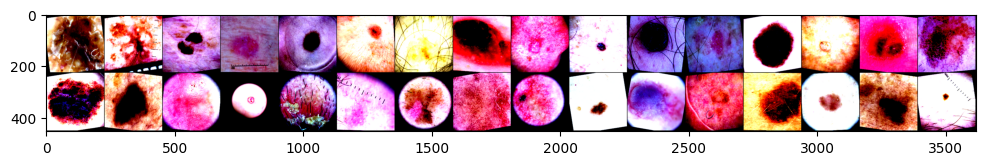

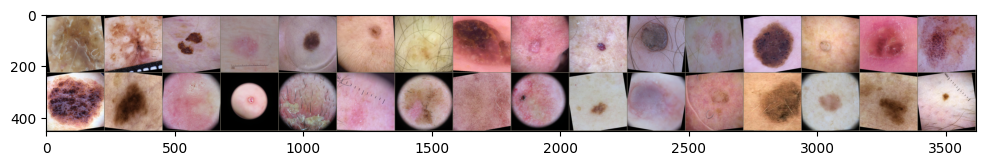

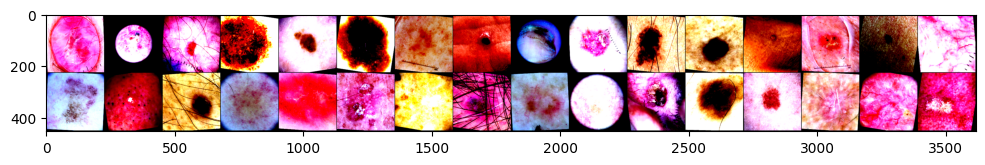

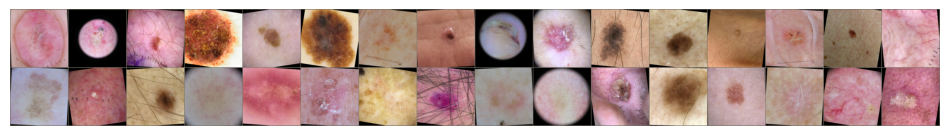

In [11]:
for images, labels in datamodule.train_dataloader():
    break
im = make_grid(images, nrow=16)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                     std=[1/0.229, 1/0.224, 1/0.225])
im = inv_normalize(im)

# تأكد من أن القيم في النطاق [0, 1]
im = torch.clamp(im, 0, 1)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.axis('off')  # لإخفاء المحاور
plt.show()

In [12]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                            precision    recall  f1-score   support

        Acitinic Keratosis     0.8505    0.8922    0.8708       102
      Basal Cell Carcinoma     0.7653    0.8427    0.8021        89
            Dermatofibroma     0.8816    0.8481    0.8645        79
                  Melanoma     0.7967    0.9074    0.8485       108
                     Nevus     0.8990    0.9674    0.9319        92
Pigmented Benign Keratosis     0.9286    0.9512    0.9398       123
      Seborrheic Keratosis     0.8485    0.6222    0.7179        90
   Squamous Cell Carcinoma     0.8919    0.8462    0.8684        78
           Vascular Lesion     0.9434    0.8197    0.8772        61

                  accuracy                         0.8625       822
                 macro avg     0.8673    0.8552    0.8579       822
              weighted avg     0.8649    0.8625    0.8605       822



    (epochs,f1_score)=(10,0.6217),(20,0.7105),(40,0.8528),(80,0.8674),(160,)

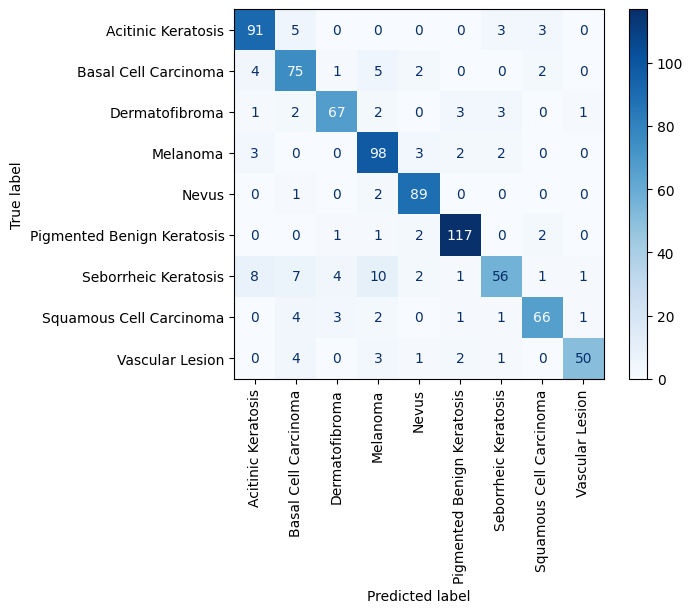

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

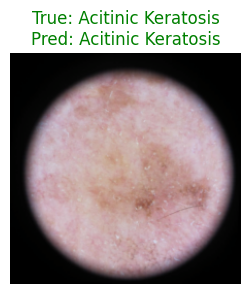

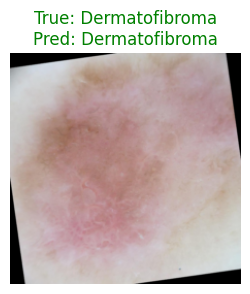

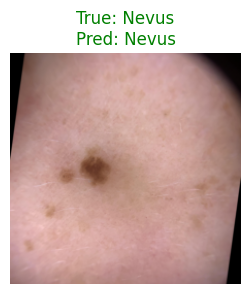

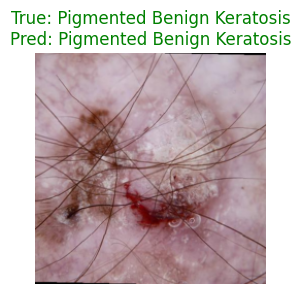

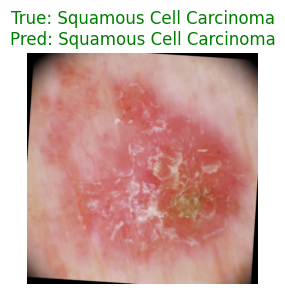

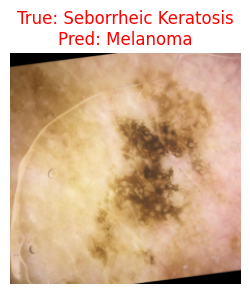

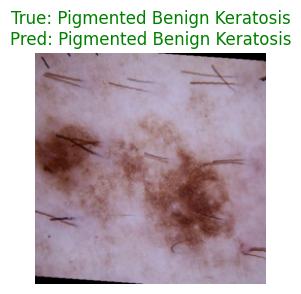

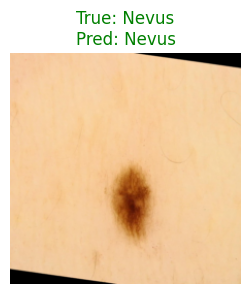

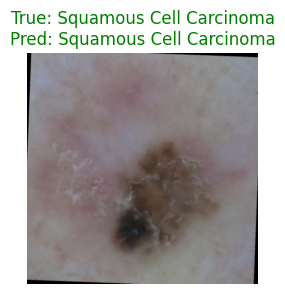

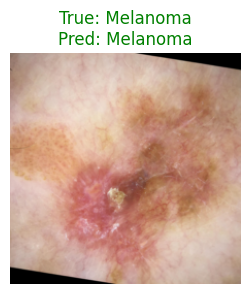

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# تحديد عدد العينات التي تريد اختبارها
num_samples = 10

# اختيار الجهاز (CPU أو GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# نقل النموذج إلى الجهاز
model = model.to(device)

# وضع النموذج في وضع التقييم
model.eval()

# الحصول على بيانات من test_dataloader
for test_data in datamodule.test_dataloader():
    test_images, test_labels = test_data[0][:num_samples], test_data[1][:num_samples]

    # نقل البيانات إلى نفس الجهاز
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    
    # الحصول على التوقعات
    with torch.no_grad():
        predictions = model(test_images).argmax(dim=1)

    # إلغاء تطبيع الصور
    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                         std=[1/0.229, 1/0.224, 1/0.225])
    test_images = torch.stack([inv_normalize(img) for img in test_images.cpu()])
    test_images = torch.clamp(test_images, 0, 1)  # التأكد أن القيم بين 0 و1

    # عرض كل صورة مع التصنيفات
    for i in range(num_samples):
        image = test_images[i]
        true_label = class_names[test_labels[i].item()]
        predicted_label = class_names[predictions[i].item()]

        # تحديد لون النص بناءً على صحة التوقع
        color = "green" if true_label == predicted_label else "red"

        # تحويل الصورة إلى الشكل المناسب للعرض
        image = image.permute(1, 2, 0).numpy()

        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.show()

    break  # يتم كسر الحلقة لأننا نريد مجموعة واحدة فقط من الصور.


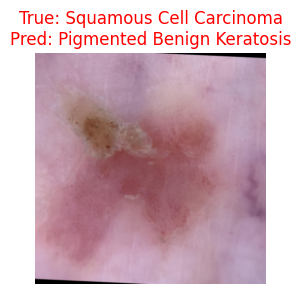

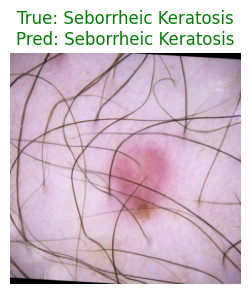

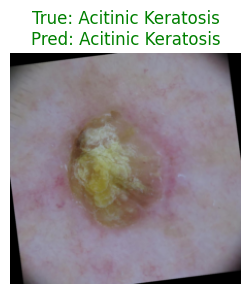

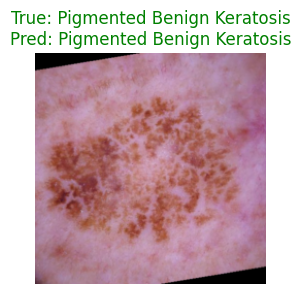

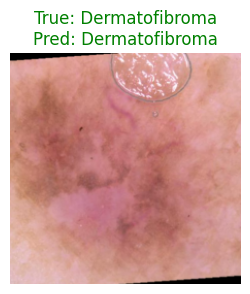

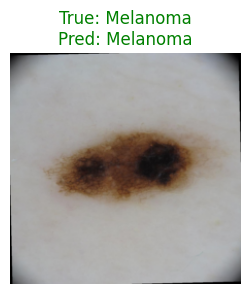

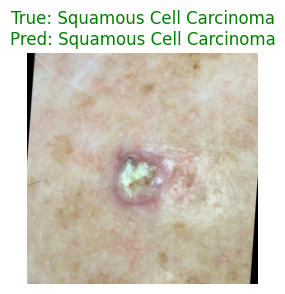

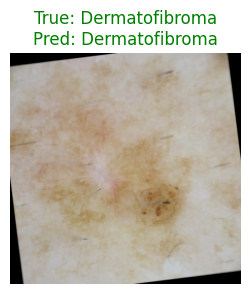

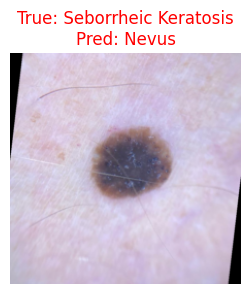

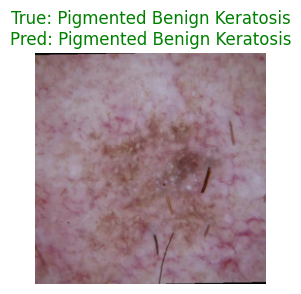

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# تحديد عدد العينات التي تريد اختبارها
num_samples = 10

# اختيار الجهاز (CPU أو GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# نقل النموذج إلى الجهاز
model = model.to(device)

# وضع النموذج في وضع التقييم
model.eval()

# إعداد بيانات الاختبار باستخدام datamodule
datamodule.setup(stage="test")
test_dataloader = datamodule.test_dataloader()

# الحصول على أسماء الفئات من ImageFolder الأصلي
class_names = datamodule.train_dataset.dataset.dataset.classes  # الوصول إلى ImageFolder الأصلي

# الحصول على أول دفعة من بيانات الاختبار
for test_data in test_dataloader:
    test_images, test_labels = test_data[0][:num_samples], test_data[1][:num_samples]

    # نقل البيانات إلى نفس الجهاز
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    
    # الحصول على التوقعات
    with torch.no_grad():
        predictions = model(test_images).argmax(dim=1)

    # إلغاء تطبيع الصور
    inv_normalize = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                         std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    test_images = torch.stack([inv_normalize(img) for img in test_images.cpu()])
    test_images = torch.clamp(test_images, 0, 1)  # التأكد أن القيم بين 0 و1

    # عرض كل صورة مع التصنيفات
    for i in range(num_samples):
        image = test_images[i]
        true_label = class_names[test_labels[i].item()]
        predicted_label = class_names[predictions[i].item()]

        # تحديد لون النص بناءً على صحة التوقع
        color = "green" if true_label == predicted_label else "red"

        # تحويل الصورة إلى الشكل المناسب للعرض
        image = image.permute(1, 2, 0).numpy()

        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.show()

    break  # يتم كسر الحلقة لأننا نريد مجموعة واحدة فقط من الصور.


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to GPU
model.eval()

example_input = torch.rand(1, 3, 224, 224).to(device)  # Move input to the same device
traced_model = torch.jit.trace(model, example_input)

traced_model.save("model_mobile_3.pt")
print("The model is saved as model_mobile_3.pt")


The model is saved as model_mobile_3.pt


In [21]:

model.eval()

# نقل النموذج إلى الجهاز المناسب
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# تحديد حجم الإدخال ونقله إلى نفس الجهاز
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # 1 صورة، 3 قنوات، حجم 224x224

# تصدير النموذج إلى ملف ONNX
onnx_filename = "skin_cancer_classification_model_3.onnx"
torch.onnx.export(model,               # النموذج
                  dummy_input,        # المدخلات العشوائية
                  onnx_filename,      # اسم الملف
                  export_params=True, # تصدير المعلمات
                  opset_version=11,   # إصدار ONNX
                  do_constant_folding=True, # تفعيل الطي الثابت
                  input_names=['input'],   # أسماء المدخلات
                  output_names=['output'],  # أسماء المخرجات
                  dynamic_axes={'input': {0: 'batch_size'},  # دعم حجم الدفعة الديناميكي
                                'output': {0: 'batch_size'}})
print(f"Model saved to {onnx_filename}")


Model saved to skin_cancer_classification_model_3.onnx
